# Analysis Team

In [2]:
#Library of LangAgent
#pip install LangAgent==0.3.0

In [7]:
# Import agents from all teams
#from LangAgent import *

In [2]:
## API Keys
import yaml
import os
from langchain_openai import ChatOpenAI
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder, PromptTemplate
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_experimental.utilities import PythonREPL


PATH_CREDENTIALS = 'credentials.yml'

# Load API keys
GROQ_API_KEY = yaml.safe_load(open('credentials.yml'))['groq']
os.environ['TAVILY_API_KEY'] = yaml.safe_load(open('credentials.yml'))['online']
os.environ['OPENWEATHERMAP_API_KEY'] = yaml.safe_load(open('credentials.yml'))['weather']
os.environ["OPENAI_API_KEY"] = yaml.safe_load(open('credentials.yml'))['openai']

MODEL = "gpt-4o-mini"
llm = ChatOpenAI(model=MODEL)


### 1. SQL Databaser

In [9]:
from LangAgent.analysis_team.agents import sql_databaser

PATH_DB = "sqlite:///data/database-sql-transactions/leads_scored.db"
sql_databaser_agent = sql_databaser(db_path=PATH_DB, llm=llm)

question = """
What are the total sales by month-year? 
Use suggested price as a proxy for revenue for each transaction and a quantity of 1. 
Make a line chart of sales over time. Add a title to the line chart
"""

initial_input = {
    "user_question": question
}

# Invoke the agent with the input
result = sql_databaser_agent.invoke(initial_input)


---ROUTER---
---GENERATE SQL---
---CONVERT DATA FRAME---
---DECIDE CHART OR TABLE---
---INSTRUCT CHART GENERATOR---
---GENERATE CHART---
---SUMMARIZE RESULTS----
---STATE PRINTER---


In [10]:
print(result['sql_query'])  # SQL Query

SELECT strftime('%m', "purchased_at") AS "month", strftime('%Y', "purchased_at") AS "year", SUM("suggested_price") AS "total_sales"
FROM transactions
JOIN products ON transactions."product_id" = products."product_id"
GROUP BY "month", "year"
ORDER BY "year", "month";


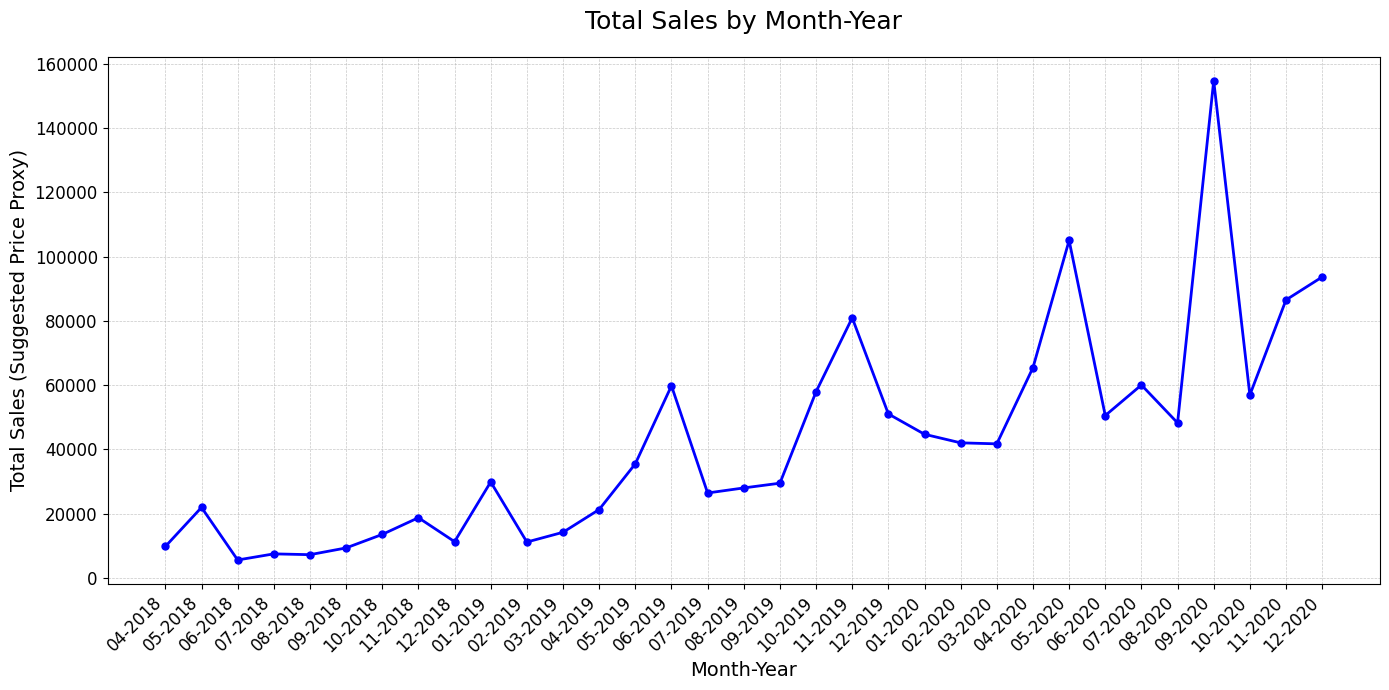

'   month_year    total_sales\n0     04-2018    9800.000000\n1     05-2018   21950.000000\n2     06-2018    5600.000000\n3     07-2018    7500.000000\n4     08-2018    7250.000000\n5     09-2018    9350.000000\n6     10-2018   13550.000000\n7     11-2018   18750.000000\n8     12-2018   11300.000000\n9     01-2019   29883.333333\n10    02-2019   11183.333333\n11    03-2019   14216.666667\n12    04-2019   21299.666667\n13    05-2019   35523.000000\n14    06-2019   59795.000000\n15    07-2019   26445.500000\n16    08-2019   28015.666667\n17    09-2019   29490.000000\n18    10-2019   57946.333333\n19    11-2019   80941.333333\n20    12-2019   51038.500000\n21    01-2020   44712.666667\n22    02-2020   42045.333333\n23    03-2020   41731.333333\n24    04-2020   65435.166667\n25    05-2020  105012.833333\n26    06-2020   50540.166667\n27    07-2020   60043.166667\n28    08-2020   48247.666667\n29    09-2020  154705.166667\n30    10-2020   56925.166667\n31    11-2020   86511.277778\n32    12-

In [11]:
# Execute the Python code for chart generation
repl = PythonREPL()
repl.run(result['chart_code'])

In [12]:
print(result['summary'])  # Summary of results

The analysis focused on total sales by month-year, using suggested prices as a proxy for revenue, with a quantity of one for each transaction. The SQL query aggregated sales data from transactions, grouping results by month and year. 

The data revealed fluctuating sales over time, with total sales starting at 9,800 in April 2018, peaking at over 154,705 in September 2020. The line chart effectively visualizes these trends, clearly displaying sales growth and seasonal variations across the analyzed period. 

Overall, the findings indicate a strong upward trajectory in sales, particularly noticeable from mid-2019 onwards, suggesting potential opportunities for further business growth and strategic planning.


### 2. Topic Generator

In [14]:
from LangAgent.analysis_team.agents import topic_generator
from sentence_transformers import SentenceTransformer
from langchain_openai import ChatOpenAI

topic_generator_agent = topic_generator(llm)

inputs = {
    'path': 'Comments.csv',
    'text_column': 'Comments',
    'user_topics': None
}

result = topic_generator_agent.invoke(inputs)

---PREPROCESS DOCUMENT---
---LOAD DOCUMENT---
---APPLY EMBEDDINGS---
---CALCULATE SILHOUETTE SCORES---


100%|██████████| 23/23 [00:02<00:00,  7.95it/s]


---FIND OPTIMAL CLUSTER---
---PERFORM KMEANS CLUSTERING---
---VISUALIZE EMBEDDINGS---
---SUMMARIZE TEXT---
---GENERATE TOPIC TITLE---
---CLUSTERING TOPICS---
Processing chunk 1/2: rows 0 to 100
Processing chunk 2/2: rows 100 to 200
---STATE PRINTER---


In [15]:
result['fig'].show()  # Show the visualization

In [16]:
result['summary_df']  # View the summarized data

,Unnamed: 0,Clothing ID,Age,Title,Comments,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,embedding,Cluster,Summary_Model,Comments_Topic
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,"[-0.12052527, 0.037070382, 0.028117895, -0.054...",1,"Silky, sexy, and comfortable; absolutely wonde...","""Customer Experiences with Fashion: Comfort, F..."
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,"[0.069891155, 0.08675883, 0.11632939, 0.007036...",0,Love this pretty dress; perfect length for my ...,"""Review Insights on Dress and Top Fit: Sizing ..."
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,"[0.026982224, 0.099774845, 0.07721407, 0.08253...",0,Dress sizing inconsistent; design flaws made i...,"""Review Insights on Dress and Top Fit: Sizing ..."
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,"[-0.118330434, 0.083309084, 0.0809608, -0.0547...",1,"Fun, flirty jumpsuit receives compliments; I a...","""Customer Experiences with Fashion: Comfort, F..."
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,"[0.0031367932, 0.054862358, -0.008802293, 0.00...",0,"Flattering, adjustable shirt pairs well with l...","""Review Insights on Dress and Top Fit: Sizing ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,194,1098,40,NaN,Dress ran very large in every way. beautiful d...,3,1,0,General,Dresses,Dresses,"[0.106921785, 0.08875683, 0.083901525, 0.03043...",0,Dress is beautiful but runs large; should have...,"""Review Insights on Dress and Top Fit: Sizing ..."
195,195,895,62,Lovely and feminine,"Finally a ""swing top"" that doesn't look like a...",5,1,9,General Petite,Tops,Fine gauge,"[0.02518151, 0.0032439053, 0.036229838, 0.0622...",1,"Flattering swing top enhances waist, lovely fa...","""Customer Experiences with Fashion: Comfort, F..."
196,196,862,26,A great piece,I bought this shirt in the neutral and white a...,5,1,2,General Petite,Tops,Knits,"[0.020141615, 0.13104847, 0.02205341, 0.054097...",0,"Love the shirt; versatile, stylish, and receiv...","""Review Insights on Dress and Top Fit: Sizing ..."
197,197,1020,38,Love everything about this skirt,"Unlike the other reviewers, i did not have any...",5,1,3,General Petite,Bottoms,Skirts,"[0.08264239, 0.05512168, 0.12150259, -0.003714...",0,Skirt fits perfectly; beautiful color and good...,"""Review Insights on Dress and Top Fit: Sizing ..."
